In [19]:
# ---------------------
# Imports and Setup
# ---------------------
import json
import uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from datetime import datetime

# Set Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# ------------------------
# Tuncated Normal Sampler
# ------------------------

def sample_truncnorm(mean, sd, low, high, size):
    a, b = (low - mean) / sd, (high - mean) / sd
    return truncnorm.rvs(a, b, loc=mean, scale=sd, size=size)

In [7]:
# --------------------------
# Population Structure
# --------------------------

# Population Size
POPULATION_SIZE = 500

# Group off of what we expect to see in a real classroom setting
groups = {
    "learning": {
        "n": int(0.20 * POPULATION_SIZE), # 20% left tail
        "mean": 0.40,
        "sd": 0.08,
        "low": 0.15,
        "high": 0.55
    },
    "practicing": {
        "n": int(0.60 * POPULATION_SIZE), # 60% median
        "mean": 0.65,
        "sd": 0.07,
        "low": 0.45,
        "high": 0.80
    },
    "mastered": {
        "n": int(0.20 * POPULATION_SIZE), # 20% right tail
        "mean": 0.90,
        "sd": 0.04,
        "low": 0.80,
        "high": 0.99
    }
}

In [11]:
# --------------------------
# HMM Probability Setup
# --------------------------

def sample_hmm_state(mastery):
    if mastery < 0.45:
        return np.random.choice(
            ["learning", "practicing"],
            p=[0.75, 0.25]
        )
    elif mastery < 0.65:
        return np.random.choice(
            ["learning", "practicing", "mastered"],
            p=[0.20, 0.65, 0.15]
        )
    elif mastery < 0.85:
        return np.random.choice(
            ["practicing", "mastered"],
            p=[0.55, 0.45]
        )
    else:
        return np.random.choice(
            ["practicing", "mastered"],
            p=[0.25, 0.75]
        )

# User Behavior Profile
def generate_behavior_profile(mastery):
    return {
        "slip_rate": float(np.clip(np.random.normal(0.10 - 0.08 * mastery, 0.02), 0.01, 0.20)),
        "guess_rate": float(np.clip(np.random.normal(0.20 - 0.15 * mastery, 0.03), 0.01, 0.30)),
        "persistence": float(np.clip(np.random.normal(0.50 + 0.40 * mastery, 0.05), 0.30, 0.95))
    }


In [15]:
# ------------------------
# Generate Users
# ------------------------

users = []

for group_name, cfg in groups.items():
    mastery_samples = sample_truncnorm(
        mean=cfg["mean"],
        sd=cfg["sd"],
        low=cfg["low"],
        high=cfg["high"],
        size=cfg["n"]
    )

    for mastery in mastery_samples:
        user = {
            "user_id": str(uuid.uuid4()),
            "latent_mastery": round(float(mastery), 3),
            "initial_state": sample_hmm_state(mastery),
            "entry_group": group_name,
            "behavior_profile": generate_behavior_profile(mastery),
            "created_at": datetime.utcnow().isoformat()
        }
        users.append(user)


C:\Users\rfull\AppData\Local\Temp\ipykernel_22396\3781092440.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat()


In [17]:
# ---------------------
# Write and export
# ---------------------

output = {
    "generation_metadata": {
        "population_size": POPULATION_SIZE,
        "distribution": "truncated_normal_mixture",
        "groups": {
            "learning": 0.20,
            "practicing": 0.60,
            "mastered": 0.20
        },
        "seed": RANDOM_SEED,
        "generated_at": datetime.utcnow().isoformat()
    },
    "users": users
}

with open("user_state_synthetic_v1.json", "w") as f:
    json.dump(output, f, indent=2)

C:\Users\rfull\AppData\Local\Temp\ipykernel_22396\2104996538.py:15: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat()


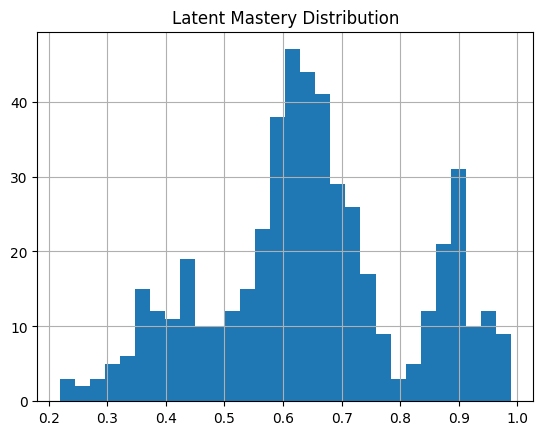

entry_group
learning      0.401450
mastered      0.899630
practicing    0.643047
Name: latent_mastery, dtype: float64

In [21]:
# Sanity Check

df = pd.DataFrame(users)

df["latent_mastery"].hist(bins=30)
plt.title("Latent Mastery Distribution")
plt.show()

df.groupby("entry_group")["latent_mastery"].mean()
